## INT2 Project
baseline from:
https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse

import time
import matplotlib.pyplot as plt
import numpy as np

In [53]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.AutoAugment(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


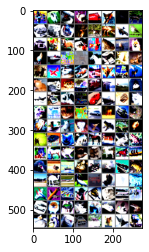

In [54]:

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imgGrid = torchvision.utils.make_grid(images)
imshow(imgGrid)
# print labels

In [51]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, dropout):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding="same")
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding="same")
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.drop1 = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.drop1(x)
        return (x)

In [52]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer0 = Block(3, 64, 0.2)
        
        self.layer1 = nn.Sequential(
            Block(64, 128, 0.3),
            Block(128, 128, 0.3)
        )
        
        self.layer2 = nn.Sequential(
            Block(128, 256, 0.4),
            Block(256, 256, 0.4)
        )
        
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(4096, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

        self.sm1 = nn.Softmax()

    def forward(self, x):
        x = self.pool(self.layer0(x))
        x = self.pool(self.layer1(x))
        x = self.pool(self.layer2(x))
        #x = self.layer3(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #x = self.fc1(x)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = self.sm1(self.fc3(x))
        x = self.fc3(x)
        return (x)

net = Net().to(device)

In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [55]:
print('==> Building model..')
#net = Net().to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

==> Building model..


In [57]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        #progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #             % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

In [58]:
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            #progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #             % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc
    print(f'epoch: {epoch}, acc: {acc}, time: {time.time()-startTime}')

In [63]:
startTime = time.time()
start_epoch = 90
for epoch in range(start_epoch, start_epoch+30):
    train(epoch)
    test(epoch)
    scheduler.step()


Epoch: 90
epoch: 90, acc: 88.12, time: 32.16507053375244

Epoch: 91
epoch: 91, acc: 89.67, time: 63.77456259727478

Epoch: 92
epoch: 92, acc: 89.0, time: 95.51443195343018

Epoch: 93
epoch: 93, acc: 88.8, time: 127.14928770065308

Epoch: 94
epoch: 94, acc: 89.28, time: 158.88634490966797

Epoch: 95
epoch: 95, acc: 88.85, time: 190.7779245376587

Epoch: 96
epoch: 96, acc: 88.72, time: 222.70063090324402

Epoch: 97
epoch: 97, acc: 89.02, time: 254.5455982685089

Epoch: 98
epoch: 98, acc: 88.92, time: 286.4636664390564

Epoch: 99
epoch: 99, acc: 89.29, time: 318.3304979801178

Epoch: 100
epoch: 100, acc: 89.67, time: 350.07318449020386

Epoch: 101
Saving..
epoch: 101, acc: 89.72, time: 381.6638648509979

Epoch: 102
epoch: 102, acc: 88.92, time: 413.34713220596313

Epoch: 103
epoch: 103, acc: 89.08, time: 445.16086173057556

Epoch: 104
epoch: 104, acc: 89.46, time: 477.11795020103455

Epoch: 105
epoch: 105, acc: 89.01, time: 508.7180256843567

Epoch: 106
Saving..
epoch: 106, acc: 89.81, t

In [ ]:
'time taken so far - 1929 + 951 + 953'

In [64]:
print(best_acc)

90.55


In [65]:
print(1929 + 951 + 953)

3833
